In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, interactive
from IPython.display import display
from src.data.data_utils import load_hsi_envi, create_file_inventory
from src.data.background_filter import create_variance_mask
from src.data.band_alignment import normalize_data_type, align_spectral_bands
from scipy.ndimage import binary_erosion, binary_dilation
from src.data.data_utils import get_wavelengths

%matplotlib inline


# Load config
with open('configs/domain_config.yaml') as f:
    config = yaml.safe_load(f)

print("✓ Setup complete")


✓ Setup complete


In [7]:
# Select domain
domain_name = 'pottery_full'
domain_config = config['domains'][domain_name]

# Get file inventory
inventory = create_file_inventory(domain_config['data_path'])

import os
file_options = {os.path.basename(f['path']): f['path'] for f in inventory}

@interact(file=Dropdown(options=file_options, description='Select File'))

def load_and_process(file):
    print(f"Loading {file}...")

    filename = os.path.basename(file)
    file_config = next((f for f in domain_config.get('file_list', []) if f['name'] == filename), {})

    crop_region = file_config.get('crop_region', domain_config.get('crop_region'))
    var_threshold_default = file_config.get('variance_threshold', domain_config.get('variance_threshold'))

    data, meta = load_hsi_envi(file)
    data = np.squeeze(data)

    # Normalize if needed
    if domain_config.get('normalize_uint16', False):
        data = normalize_data_type(data, domain_config['data_type'])

    # Skip alignment — just use available bands
    print(f"Using original {data.shape[2]} bands (no alignment applied)")

    # Band selection
    wavelengths = get_wavelengths(meta)
    wavelength_range = file_config.get('wavelength_range', domain_config.get('masking_wavelength_range', {}).get('wavelength_range'))
    MIN_WAVELENGTH, MAX_WAVELENGTH = wavelength_range if wavelength_range else (None, None)
    if wavelengths is not None:
        band_indices = np.where((wavelengths >= MIN_WAVELENGTH) & 
                                (wavelengths <= MAX_WAVELENGTH))[0]
        data = data[:, :, band_indices]
        wavelengths = wavelengths[band_indices]
        print(f"Selected {len(band_indices)} bands: {MIN_WAVELENGTH}-{MAX_WAVELENGTH} nm")
    else:
        print("No wavelength info - using all bands")
        wavelengths = None

    height, width, bands = data.shape
    print(f"Loaded: {height}×{width}×{bands}")

    # ===== RGB Band Selection =====
    if wavelengths is not None:
        RED_WAVELENGTH = 2000
        GREEN_WAVELENGTH = 1650
        BLUE_WAVELENGTH = 1100

        def find_closest_band(target_nm, wavelengths):
            return np.argmin(np.abs(wavelengths - target_nm))

        red_idx = find_closest_band(RED_WAVELENGTH, wavelengths)
        green_idx = find_closest_band(GREEN_WAVELENGTH, wavelengths)
        blue_idx = find_closest_band(BLUE_WAVELENGTH, wavelengths)

        rgb_image = np.stack([
            data[:, :, red_idx],
            data[:, :, green_idx],
            data[:, :, blue_idx]
        ], axis=-1)

        rgb_image = rgb_image.astype(np.float32)
        rgb_image -= rgb_image.min()
        rgb_image /= rgb_image.max()
    else:
        rgb_image = None

    # Interactive crop and mask
    @interact(
    top=IntSlider(min=0, max=height-1, value=crop_region['top'], description='Top:', continuous_update=False),
    bottom=IntSlider(min=1, max=height, value=crop_region['bottom'], description='Bottom:', continuous_update=False),
    left=IntSlider(min=0, max=width-1, value=crop_region['left'], description='Left:', continuous_update=False),
    right=IntSlider(min=1, max=width, value=crop_region['right'], description='Right:', continuous_update=False),
    var_threshold=FloatSlider(min=0.01, max=0.5, step=0.01, value=var_threshold_default, description='Variance:', continuous_update=False),
    morph_iter=IntSlider(min=0, max=10, value=2, description='Cleanup:', continuous_update=False)
    )
    def tune_crop_and_mask(top, bottom, left, right, var_threshold, morph_iter):
        bottom = max(top + 1, min(bottom, height))
        right = max(left + 1, min(right, width))

        cropped = data[top:bottom, left:right, :]

        spectral_var = np.var(cropped, axis=2)
        threshold_value = var_threshold * spectral_var.max()
        mask = spectral_var > threshold_value

        if morph_iter > 0:
            mask = binary_erosion(mask, iterations=morph_iter)
            mask = binary_dilation(mask, iterations=morph_iter)

        masked = cropped.copy()
        masked[~mask] = 0

        useful_pixels = np.sum(mask)
        total_pixels = mask.size
        useful_percent = 100 * useful_pixels / total_pixels

        fig, axes = plt.subplots(2, 3, figsize=(18, 30))

        mean_original = np.mean(data, axis=2)
        axes[0, 0].imshow(mean_original, cmap='gray', aspect='auto')
        from matplotlib.patches import Rectangle
        rect = Rectangle((left, top), right-left, bottom-top,
                         linewidth=3, edgecolor='red', facecolor='none')
        axes[0, 0].add_patch(rect)
        axes[0, 0].set_title(f'Original: {height}×{width}\n({bands} selected bands)', 
                             fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('X')
        axes[0, 0].set_ylabel('Y')

        mean_cropped = np.mean(cropped, axis=2)
        axes[0, 1].imshow(mean_cropped, cmap='gray', aspect='auto')
        axes[0, 1].set_title(f'Cropped: {cropped.shape[0]}×{cropped.shape[1]}', 
                             fontsize=12, fontweight='bold')

        axes[1, 0].imshow(mask, cmap='RdYlGn', aspect='auto')
        axes[1, 0].set_title(f'Mask\n{useful_percent:.1f}% useful', 
                             fontsize=12, fontweight='bold')

        mean_masked = np.mean(masked, axis=2)
        axes[1, 1].imshow(mean_masked, cmap='gray', aspect='auto')
        axes[1, 1].set_title(f'Final Result', fontsize=12, fontweight='bold')

        if rgb_image is not None:
            rgb_crop = rgb_image[top:bottom, left:right, :]
            axes[0, 2].imshow(rgb_crop)
            axes[0, 2].set_title(f'RGB Composite\nR={RED_WAVELENGTH}nm, G={GREEN_WAVELENGTH}nm, B={BLUE_WAVELENGTH}nm',
                                 fontsize=12, fontweight='bold')

        plt.tight_layout()
        output_path = os.path.join("visualizations", "data_processing", f"{filename.replace('.hdr','')}_{top}_{bottom}_{left}_{right}.png")
        plt.savefig(output_path, dpi=300)
        print(f"Saved image to: {output_path}")

        print(f"\nParameters for {domain_name}:")
        print(f"  Crop: top={top}, bottom={bottom}, left={left}, right={right}")
        print(f"  Variance threshold: {var_threshold}")
        print(f"  Useful pixels: {useful_percent:.1f}%")

interactive(children=(Dropdown(description='Select File', options={'Scherben_3_SWIR_320m_SN3505_2600_us_2011-0…

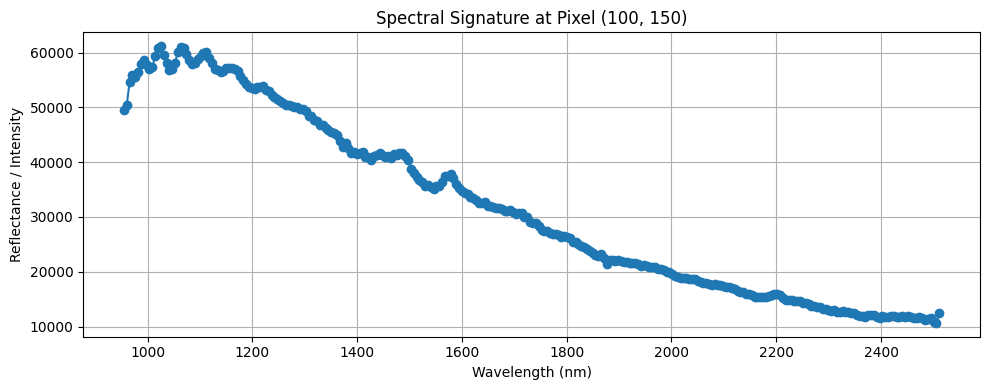

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from src.data.data_utils import load_hsi_envi, get_wavelengths

# Load the hyperspectral image
file_path = r"data/sugar/WTReihe_WTQ2_SWIR_3122_4000_us_1x_2016-04-01T145834_raw2_rad.hdr"
data, meta = load_hsi_envi(file_path)
data = np.squeeze(data)  # Remove singleton dimensions if needed

# Get wavelengths
wavelengths = get_wavelengths(meta)
if wavelengths is None:
    wavelengths = np.arange(data.shape[2])  # fallback if no metadata

# Choose a pixel (row, col)
row, col = 100, 150  # adjust as needed
spectrum = data[row, col, :]

# Plot the spectral signature
plt.figure(figsize=(10, 4))
plt.plot(wavelengths, spectrum, marker='o')
plt.title(f"Spectral Signature at Pixel ({row}, {col})")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance / Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

Keys in .npz file: ['data', 'mask', 'stats']
Filtered shape: (1334, 320, 256)
Mask shape: (1334, 320)
Useful pixel ratio: 0.40521458020989504
Bands used for masking: 136


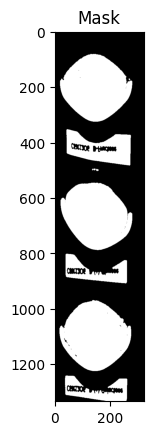

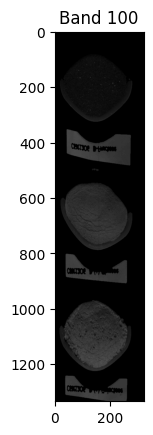

In [5]:
import numpy as np

# Load the file
data = np.load("data_processed/sugar_000.npz", allow_pickle=True)  # change path and filename as needed

# List all keys in the archive
print("Keys in .npz file:", data.files)

# Access arrays
filtered = data['data']
mask = data['mask']
stats = data['stats'].item()  # stats is stored as a Python dict

# Show basic info
print("Filtered shape:", filtered.shape)
print("Mask shape:", mask.shape)
print("Useful pixel ratio:", stats['mask_stats']['useful_ratio'])
print("Bands used for masking:", stats['masking_info']['bands_used_for_masking'])


import matplotlib.pyplot as plt

plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

plt.imshow(filtered[:, :, 100], cmap='gray')  # show band 100
plt.title("Band 100")
plt.show()

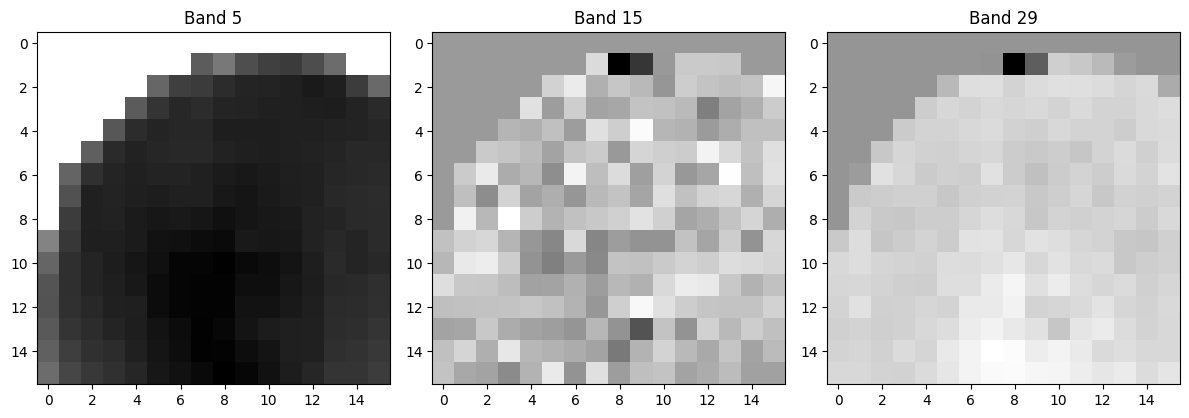

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Load the patch file (example: sugar)
patch_data = np.load("data_patches_pca/grapes_patches.npz", allow_pickle=True)

# Access patches
patches = patch_data['patches']  # shape: (N, 16, 16, 256)
positions = patch_data['positions']
file_ids = patch_data['file_ids']

# Pick a patch to view (e.g., index 0)
patch = patches[0]  # shape: (16, 16, 256)

# Visualize a few spectral bands
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, band in enumerate([5, 15, 29]):
    axes[i].imshow(patch[:, :, band], cmap='gray')
    axes[i].set_title(f"Band {band}")
plt.tight_layout()
plt.show()

In [12]:
import torch
import torch.nn as nn

# Simulate your model input
batch_sizes = [8, 16, 24, 32, 48, 64]

for bs in batch_sizes:
    try:
        # Simulate batch
        x = torch.randn(bs, 30, 16, 16).cuda()
        
        # Simulate forward pass (rough approximation)
        model = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(7,3,3)),
            nn.Flatten(),
            nn.Linear(16*15*4*4, 240*64),
        ).cuda()
        
        output = model(x.unsqueeze(1))
        
        # Check memory
        allocated = torch.cuda.memory_allocated() / 1e9
        print(f"Batch {bs}: {allocated:.2f} GB - ✓ OK")
        
        del x, output, model
        torch.cuda.empty_cache()
        
    except RuntimeError as e:
        print(f"Batch {bs}: ❌ OOM (Out of Memory)")
        break


Batch 8: ❌ OOM (Out of Memory)


In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the PCA model
with open(r'D:\Thesis_new\data_patches_pca\pca_model.pkl', 'rb') as f:
    pca = pickle.load(f)

# Print basic info
print("="*80)
print(" PCA Model Summary ".center(80, "="))
print("="*80)
print(f"Number of components: {pca.n_components_}")
print(f"Original dimensions: {pca.n_features_in_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"\nFirst 10 components variance:")
for i in range(min(10, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)")

# Cumulative variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
print(f"\nCumulative variance explained by 30 components: {cumvar[29]:.4f} ({cumvar[29]*100:.2f}%)")


============================== PCA Model Summary ===============================
Number of components: 30
Original dimensions: 256
Total variance explained: 1.0004 (100.04%)

First 10 components variance:
  PC1: 0.9525 (95.25%)
  PC2: 0.0316 (3.16%)
  PC3: 0.0035 (0.35%)
  PC4: 0.0018 (0.18%)
  PC5: 0.0017 (0.17%)
  PC6: 0.0014 (0.14%)
  PC7: 0.0011 (0.11%)
  PC8: 0.0011 (0.11%)
  PC9: 0.0009 (0.09%)
  PC10: 0.0009 (0.09%)

Cumulative variance explained by 30 components: 1.0004 (100.04%)


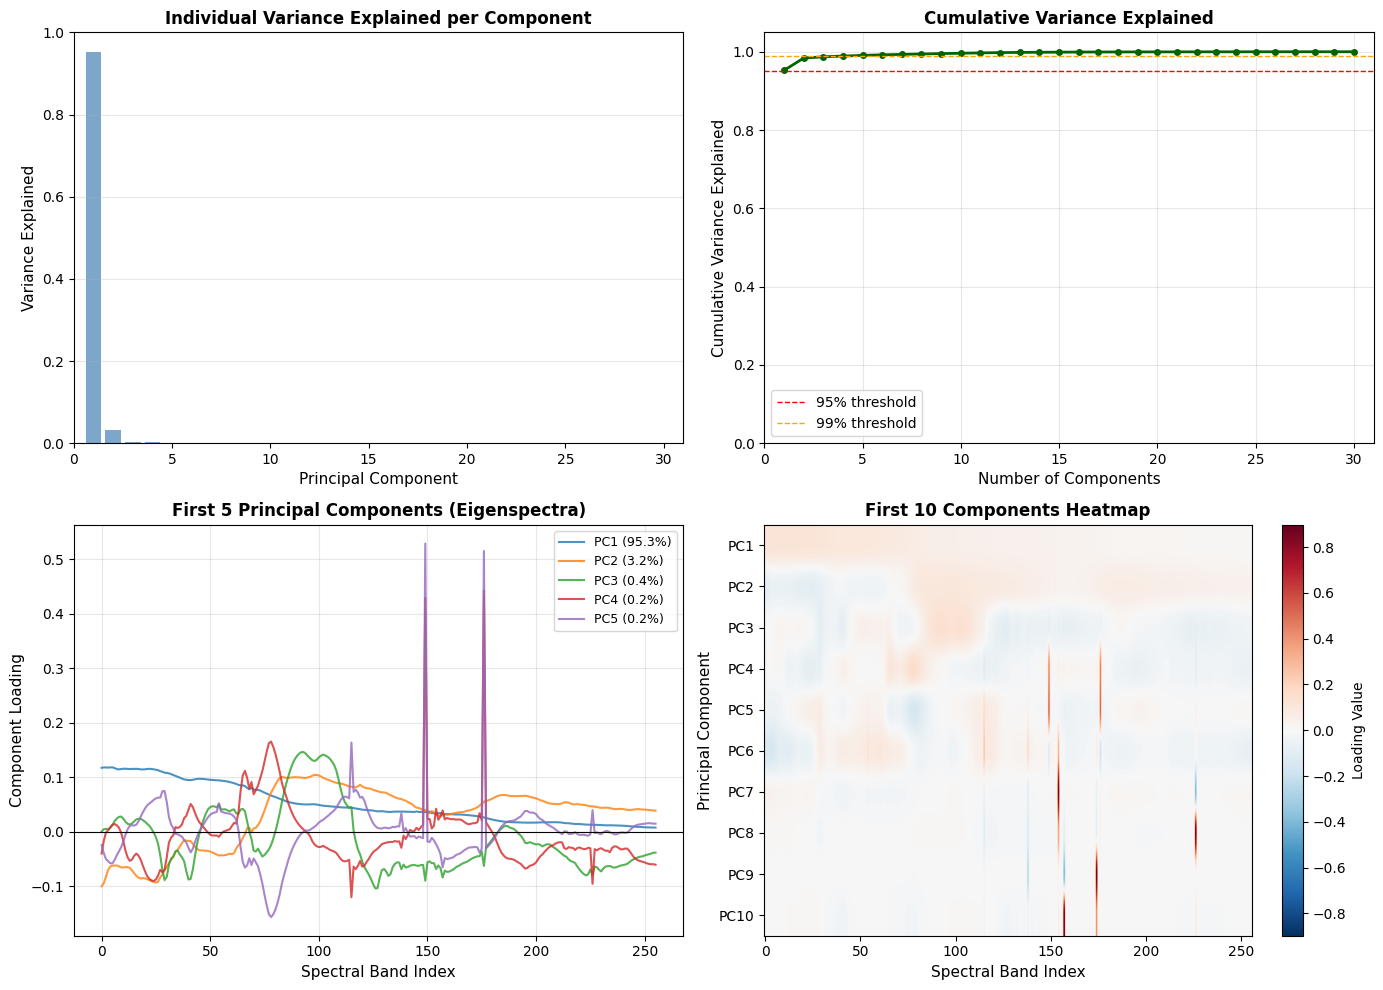


✓ Visualization saved as 'pca_analysis.png'


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Explained Variance Ratio
ax1 = axes[0, 0]
ax1.bar(range(1, 31), pca.explained_variance_ratio_[:30], color='steelblue', alpha=0.7)
ax1.set_xlabel('Principal Component', fontsize=11)
ax1.set_ylabel('Variance Explained', fontsize=11)
ax1.set_title('Individual Variance Explained per Component', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_xlim(0, 31)

# 2. Cumulative Variance
ax2 = axes[0, 1]
ax2.plot(range(1, 31), np.cumsum(pca.explained_variance_ratio_[:30]), 
         marker='o', linewidth=2, color='darkgreen', markersize=4)
ax2.axhline(0.95, color='red', linestyle='--', linewidth=1, label='95% threshold')
ax2.axhline(0.99, color='orange', linestyle='--', linewidth=1, label='99% threshold')
ax2.set_xlabel('Number of Components', fontsize=11)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=11)
ax2.set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xlim(0, 31)
ax2.set_ylim(0, 1.05)

# 3. First 5 Principal Components (eigenspectra)
ax3 = axes[1, 0]
for i in range(5):
    ax3.plot(pca.components_[i], label=f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.1f}%)', 
             linewidth=1.5, alpha=0.8)
ax3.set_xlabel('Spectral Band Index', fontsize=11)
ax3.set_ylabel('Component Loading', fontsize=11)
ax3.set_title('First 5 Principal Components (Eigenspectra)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)
ax3.axhline(0, color='black', linewidth=0.8, linestyle='-')

# 4. Heatmap of first 10 components
ax4 = axes[1, 1]
im = ax4.imshow(pca.components_[:10], aspect='auto', cmap='RdBu_r', 
                vmin=-np.abs(pca.components_[:10]).max(), 
                vmax=np.abs(pca.components_[:10]).max())
ax4.set_xlabel('Spectral Band Index', fontsize=11)
ax4.set_ylabel('Principal Component', fontsize=11)
ax4.set_title('First 10 Components Heatmap', fontsize=12, fontweight='bold')
ax4.set_yticks(range(10))
ax4.set_yticklabels([f'PC{i+1}' for i in range(10)])
plt.colorbar(im, ax=ax4, label='Loading Value')

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'pca_analysis.png'")


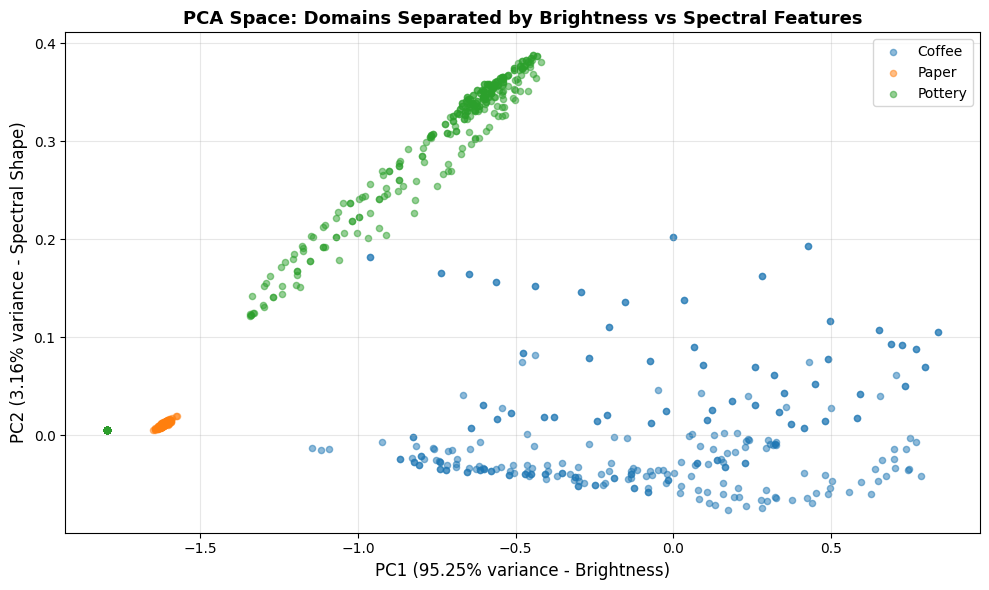

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

# Load PCA model
with open(r'D:\Thesis_new\data_patches_pca\pca_model.pkl', 'rb') as f:
    pca = pickle.load(f)

# Load some sample data
data = np.load(r'D:\Thesis_new\data_patches_pca\coffee_patches.npz')
coffee_pca = data['patches'].reshape(-1, 30)[:500]  # First 500 pixels

data = np.load(r'D:\Thesis_new\data_patches_pca\paper_patches.npz')
paper_pca = data['patches'].reshape(-1, 30)[:500]

data = np.load(r'D:\Thesis_new\data_patches_pca\pottery_patches.npz')
pottery_pca = data['patches'].reshape(-1, 30)[:500]

# Plot PC1 vs PC2
plt.figure(figsize=(10, 6))
plt.scatter(coffee_pca[:, 0], coffee_pca[:, 1], alpha=0.5, label='Coffee', s=20)
plt.scatter(paper_pca[:, 0], paper_pca[:, 1], alpha=0.5, label='Paper', s=20)
plt.scatter(pottery_pca[:, 0], pottery_pca[:, 1], alpha=0.5, label='Pottery', s=20)
plt.xlabel('PC1 (95.25% variance - Brightness)', fontsize=12)
plt.ylabel('PC2 (3.16% variance - Spectral Shape)', fontsize=12)
plt.title('PCA Space: Domains Separated by Brightness vs Spectral Features', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pca_domain_separation.png', dpi=300)
plt.show()


In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def extract_losses_from_checkpoints(checkpoint_dir, max_epoch=360):
    """
    Extract losses from all checkpoint files
    """
    checkpoint_dir = Path(checkpoint_dir)
    
    epochs = []
    simclr_losses = []
    mae_losses = []
    total_losses = []
    
    # Iterate through checkpoints (10, 20, 30, ..., 360)
    for epoch in range(10, max_epoch + 1, 10):
        checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch}.pt"
        
        if checkpoint_path.exists():
            print(f"Loading checkpoint: {checkpoint_path.name}")
            
            try:
                # Load checkpoint
                checkpoint = torch.load(checkpoint_path, map_location='cpu')
                
                # Extract losses
                if 'losses' in checkpoint:
                    losses = checkpoint['losses']
                    
                    epochs.append(epoch)
                    total_losses.append(losses.get('total', 0))
                    simclr_losses.append(losses.get('simclr', 0))
                    mae_losses.append(losses.get('mae', 0))
                    
                    print(f"  Epoch {epoch}: Total={losses.get('total', 0):.4f}, "
                          f"SimCLR={losses.get('simclr', 0):.4f}, "
                          f"MAE={losses.get('mae', 0):.4f}")
                else:
                    print(f"  Warning: No 'losses' key in checkpoint")
                    
            except Exception as e:
                print(f"  Error loading checkpoint: {e}")
        else:
            print(f"Checkpoint not found: {checkpoint_path.name}")
    
    return epochs, total_losses, simclr_losses, mae_losses


def plot_training_curves(epochs, total_losses, simclr_losses, mae_losses, output_dir='outputs'):
    """
    Create comprehensive training loss plots
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # ========== Plot 1: All Losses Together ==========
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(epochs, total_losses, 'o-', linewidth=2, markersize=6, 
            label='Total Loss', color='#2E86AB')
    ax.plot(epochs, simclr_losses, 's-', linewidth=2, markersize=6, 
            label='SimCLR Loss', color='#A23B72')
    ax.plot(epochs, mae_losses, '^-', linewidth=2, markersize=6, 
            label='MAE Loss', color='#F18F01')
    
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title('Training Loss Curves (360 Epochs)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'training_losses_all.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'training_losses_all.pdf', bbox_inches='tight')
    print(f"Saved: {output_dir / 'training_losses_all.png'}")
    plt.close()
    
    # ========== Plot 2: Separate Subplots ==========
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Total Loss
    axes[0].plot(epochs, total_losses, 'o-', linewidth=2, markersize=6, color='#2E86AB')
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Total Loss', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # SimCLR Loss
    axes[1].plot(epochs, simclr_losses, 's-', linewidth=2, markersize=6, color='#A23B72')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Loss', fontsize=11)
    axes[1].set_title('SimCLR Contrastive Loss', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # MAE Loss
    axes[2].plot(epochs, mae_losses, '^-', linewidth=2, markersize=6, color='#F18F01')
    axes[2].set_xlabel('Epoch', fontsize=11)
    axes[2].set_ylabel('Loss', fontsize=11)
    axes[2].set_title('MAE Reconstruction Loss', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'training_losses_separate.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'training_losses_separate.pdf', bbox_inches='tight')
    print(f"Saved: {output_dir / 'training_losses_separate.png'}")
    plt.close()
    
    # ========== Plot 3: Log Scale (if needed) ==========
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(epochs, total_losses, 'o-', linewidth=2, markersize=6, 
            label='Total Loss', color='#2E86AB')
    ax.plot(epochs, simclr_losses, 's-', linewidth=2, markersize=6, 
            label='SimCLR Loss', color='#A23B72')
    ax.plot(epochs, mae_losses, '^-', linewidth=2, markersize=6, 
            label='MAE Loss', color='#F18F01')
    
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss (log scale)', fontsize=12, fontweight='bold')
    ax.set_title('Training Loss Curves - Log Scale', fontsize=14, fontweight='bold')
    ax.set_yscale('log')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'training_losses_log.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir / 'training_losses_log.png'}")
    plt.close()
    
    # ========== Plot 4: Loss Components Ratio ==========
    fig, ax = plt.subplots(figsize=(12, 6))
    
    simclr_ratio = np.array(simclr_losses) / np.array(total_losses) * 100
    mae_ratio = np.array(mae_losses) / np.array(total_losses) * 100
    
    ax.plot(epochs, simclr_ratio, 's-', linewidth=2, markersize=6, 
            label='SimCLR % of Total', color='#A23B72')
    ax.plot(epochs, mae_ratio, '^-', linewidth=2, markersize=6, 
            label='MAE % of Total', color='#F18F01')
    
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage of Total Loss (%)', fontsize=12, fontweight='bold')
    ax.set_title('Loss Component Contribution Over Training', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 100])
    
    plt.tight_layout()
    plt.savefig(output_dir / 'loss_component_ratio.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir / 'loss_component_ratio.png'}")
    plt.close()


def print_loss_statistics(epochs, total_losses, simclr_losses, mae_losses):
    """
    Print summary statistics
    """
    print("\n" + "="*60)
    print("TRAINING LOSS STATISTICS")
    print("="*60)
    
    print(f"\nTotal Loss:")
    print(f"  Initial (epoch {epochs[0]}): {total_losses[0]:.4f}")
    print(f"  Final (epoch {epochs[-1]}):  {total_losses[-1]:.4f}")
    print(f"  Reduction: {(total_losses[0] - total_losses[-1]):.4f} ({(1 - total_losses[-1]/total_losses[0])*100:.1f}%)")
    print(f"  Min: {min(total_losses):.4f} at epoch {epochs[total_losses.index(min(total_losses))]}")
    
    print(f"\nSimCLR Loss:")
    print(f"  Initial (epoch {epochs[0]}): {simclr_losses[0]:.4f}")
    print(f"  Final (epoch {epochs[-1]}):  {simclr_losses[-1]:.4f}")
    print(f"  Reduction: {(simclr_losses[0] - simclr_losses[-1]):.4f} ({(1 - simclr_losses[-1]/simclr_losses[0])*100:.1f}%)")
    
    print(f"\nMAE Loss:")
    print(f"  Initial (epoch {epochs[0]}): {mae_losses[0]:.4f}")
    print(f"  Final (epoch {epochs[-1]}):  {mae_losses[-1]:.4f}")
    print(f"  Reduction: {(mae_losses[0] - mae_losses[-1]):.4f} ({(1 - mae_losses[-1]/mae_losses[0])*100:.1f}%)")
    
    print("\n" + "="*60)


def main():
    # Configuration
    checkpoint_dir = "temp"
    output_dir = "outputs/training_analysis"
    max_epoch = 360
    
    print("="*60)
    print("EXTRACTING TRAINING LOSSES FROM CHECKPOINTS")
    print("="*60)
    print(f"Checkpoint directory: {checkpoint_dir}")
    print(f"Max epoch: {max_epoch}")
    print()
    
    # Extract losses
    epochs, total_losses, simclr_losses, mae_losses = extract_losses_from_checkpoints(
        checkpoint_dir, max_epoch
    )
    
    if len(epochs) == 0:
        print("\nError: No checkpoints found or no losses in checkpoints!")
        return
    
    print(f"\nSuccessfully loaded {len(epochs)} checkpoints")
    
    # Print statistics
    print_loss_statistics(epochs, total_losses, simclr_losses, mae_losses)
    
    # Create plots
    print("\nGenerating plots...")
    plot_training_curves(epochs, total_losses, simclr_losses, mae_losses, output_dir)
    
    print("\n" + "="*60)
    print("COMPLETE! Check outputs in:", output_dir)
    print("="*60)


if __name__ == "__main__":
    main()


EXTRACTING TRAINING LOSSES FROM CHECKPOINTS
Checkpoint directory: temp
Max epoch: 360

Loading checkpoint: checkpoint_epoch_10.pt
  Epoch 10: Total=2.0931, SimCLR=2.0043, MAE=0.0888
Loading checkpoint: checkpoint_epoch_20.pt
  Epoch 20: Total=2.0696, SimCLR=1.9866, MAE=0.0830
Loading checkpoint: checkpoint_epoch_30.pt
  Epoch 30: Total=2.0411, SimCLR=1.9692, MAE=0.0719
Loading checkpoint: checkpoint_epoch_40.pt
  Epoch 40: Total=2.0635, SimCLR=1.9818, MAE=0.0817
Loading checkpoint: checkpoint_epoch_50.pt
  Epoch 50: Total=2.0464, SimCLR=1.9711, MAE=0.0753
Loading checkpoint: checkpoint_epoch_60.pt
  Epoch 60: Total=2.0305, SimCLR=1.9619, MAE=0.0686
Loading checkpoint: checkpoint_epoch_70.pt
  Epoch 70: Total=2.0192, SimCLR=1.9558, MAE=0.0634
Loading checkpoint: checkpoint_epoch_80.pt
  Epoch 80: Total=2.0564, SimCLR=1.9784, MAE=0.0781
Loading checkpoint: checkpoint_epoch_90.pt
  Epoch 90: Total=2.0487, SimCLR=1.9721, MAE=0.0766
Loading checkpoint: checkpoint_epoch_100.pt
  Epoch 100: T